# Testing non-linear solvers on the Rosenbrock function

@Author: Ettore Biondi - ebiondi@caltech.edu

## Problem definition

In this notebook we show how to set a user-defined objective function and minimize it using different solvers.
The function understudy is the well-known convex Rosenbrock function. Its analytical form for the 2D case takes the follwing form:
\begin{equation}
\phi(x,y) = (1-x)^2 + 100 (y-x^2)^2,
\end{equation}
in which the unique global minimum is at $x=y=1$. The global minimum is inside a long, narrow, parabolic-shaped flat valley. To find the valley is trivial. To converge to the global minimum, however, is difficult. Hence, this function represents a good testing case for any non-linear optimization scheme.

In [1]:
import numpy as np
import occamypy
#Plotting library
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex':False
}
matplotlib.rcParams.update(params)

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


Let's first define the problem object. Our model vector is going to be $\mathbf{m} = [x \,, \, y]^T$. Since the libary assumes that the objective function is written in terms of some residual vector (i.e., $\phi(\mathbf{r}(\mathbf{m}))$, we will create a vector containing objective function as a single scalar value. 

In [2]:
class Rosenbrock(occamypy.Problem):
	"""
	   Rosenbrock function inverse problem
	   f(x,y) = (1 - x)^2 + 100*(y -x^2)^2
	   m = [x y]'
	   res = objective function value
	"""

	def __init__(self, x_initial, y_initial, minBound=None, maxBound=None):
		"""Constructor of linear problem"""
		#Setting the bounds (if any)
		super(Rosenbrock, self).__init__(minBound, maxBound)
		#Setting initial model
		self.model = occamypy.VectorNumpy(np.array((x_initial, y_initial)))
		self.dmodel = self.model.clone()
		self.dmodel.zero()
		#Gradient vector
		self.grad  =self.dmodel.clone()
		#Residual vector
		self.res = occamypy.VectorNumpy(np.array((0.,)))
		#Dresidual vector
		self.dres = self.res.clone()
		#Setting default variables
		self.setDefaults()
		self.linear = False
		return

	def objf(self, model):
		"""Objective function computation"""
		m = model.getNdArray() #Getting ndArray of the model
		obj = self.res.arr[0]
		return obj

	def resf(self, model):
		"""Residual function"""
		m = model.getNdArray() #Getting ndArray of the model
		self.res.getNdArray()[0] = (1.0 - m[0])*(1.0 - m[0]) + 100.0 * (m[1] - m[0]*m[0]) * (m[1] - m[0]*m[0])
		return self.res

	def gradf(self, model, res):
		"""Gradient computation"""
		m = model.getNdArray() #Getting ndArray of the model
		self.grad.getNdArray()[0] = - 2.0 * (1.0 - m[0]) - 400.0 * m[0] * (m[1] - m[0]*m[0])
		self.grad.getNdArray()[1] = 200.0 * (m[1] - m[0]*m[0])
		return self.grad

	def dresf(self, model, dmodel):
		"""Linear variation of the objective function value"""
		m = model.getNdArray() #Getting ndArray of the model
		dm = dmodel.getNdArray() #Getting ndArray of the model
		self.dres.arr[0] = (- 2.0 * (1.0 - m[0]) - 400.0 * m[0] * (m[1] - m[0]*m[0]))* dm[0] + (200.0 * (m[1] - m[0]*m[0])) * dm[1]
		return self.dres

### Instantiation of the inverse problem and of the various solvers

In [3]:
#Starting point for all the optimization problem
x_init = -1.0
y_init = -1.0
#Testing solver on Rosenbrock function
Ros_prob = Rosenbrock(x_init, y_init)

Before running any inversion, let's compute the objective function for different values of $x$ and $y$. This step will be useful when we want to plot the optimization path taken by the various tested algorithms.

In [4]:
#Computing the objective function for plotting
x_samples = np.linspace(-1.5,  1.5, 1000)
y_samples = np.linspace(   3, -1.5, 1000)

obj_ros = occamypy.VectorNumpy((x_samples.size, y_samples.size))
model_test = occamypy.VectorNumpy(np.array((0., 0.)))

for ix, x_value in enumerate(x_samples):
	for iy, y_value in enumerate(y_samples):
		model_test[0]  = x_value
		model_test[1]  = y_value
		obj_ros[ix, iy] = Ros_prob.get_obj(model_test)

First we test a non-linear conjugate-gradient method in which a parabolic stepper with three-point interpolation is used. 

In [5]:
niter = 1000
Stop  = occamypy.BasicStopper(niter=niter, tolr=1e-32, tolg=1e-32)
NLCGsolver = occamypy.NLCG(Stop)
Ros_prob = Rosenbrock(x_init, y_init) #Resetting the problem
NLCGsolver.setDefaults(save_obj=True, save_model=True)
NLCGsolver.run(Ros_prob,verbose=True)
#Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(NLCGsolver.model)):
    x_smpld.append(NLCGsolver.model[i].getNdArray()[0])
    y_smpld.append(NLCGsolver.model[i].getNdArray()[1])

##########################################################################################
			NON-LINEAR CONJUGATE GRADIENT SOLVER 
	Restart folder: /tmp/restart_2021-02-17T11-07-14.580164/
	Conjugate method used: FR
##########################################################################################

iter = 0000, obj = 4.04000e+02, resnorm = 4.04e+02, gradnorm = 8.98e+02, feval = 1, geval = 1
iter = 0001, obj = 4.00632e+01, resnorm = 4.01e+01, gradnorm = 1.33e+02, feval = 4, geval = 2
iter = 0002, obj = 1.75421e+00, resnorm = 1.75e+00, gradnorm = 1.87e+01, feval = 7, geval = 3
iter = 0003, obj = 8.70442e-01, resnorm = 8.70e-01, gradnorm = 1.88e+00, feval = 10, geval = 4
iter = 0004, obj = 8.39754e-01, resnorm = 8.40e-01, gradnorm = 1.81e+00, feval = 13, geval = 5
iter = 0005, obj = 7.38115e-01, resnorm = 7.38e-01, gradnorm = 2.27e+00, feval = 16, geval = 6
iter = 0006, obj = 5.41088e-01, resnorm = 5.41e-01, gradnorm = 4.40e+00, feval = 19, geval = 7
iter = 0007, obj = 4.82647e-0

iter = 0161, obj = 3.87719e-23, resnorm = 3.88e-23, gradnorm = 1.42e-10, feval = 495, geval = 162
iter = 0162, obj = 1.64103e-23, resnorm = 1.64e-23, gradnorm = 5.83e-11, feval = 498, geval = 163
iter = 0163, obj = 1.33357e-23, resnorm = 1.33e-23, gradnorm = 2.00e-11, feval = 501, geval = 164
iter = 0164, obj = 1.29649e-23, resnorm = 1.30e-23, gradnorm = 7.56e-12, feval = 504, geval = 165
iter = 0165, obj = 1.28896e-23, resnorm = 1.29e-23, gradnorm = 6.29e-12, feval = 507, geval = 166
iter = 0166, obj = 1.27154e-23, resnorm = 1.27e-23, gradnorm = 1.37e-11, feval = 510, geval = 167
iter = 0167, obj = 1.11972e-23, resnorm = 1.12e-23, gradnorm = 4.00e-11, feval = 513, geval = 168
iter = 0168, obj = 5.06377e-24, resnorm = 5.06e-24, gradnorm = 5.39e-11, feval = 516, geval = 169
iter = 0169, obj = 1.57404e-24, resnorm = 1.57e-24, gradnorm = 2.27e-11, feval = 519, geval = 170
iter = 0170, obj = 1.12618e-24, resnorm = 1.13e-24, gradnorm = 7.02e-12, feval = 522, geval = 171
iter = 0171, obj = 1

Let's plot the optimization path taken by the algorithm, which converged to the global minimum in 199 iterations using a parabolic stepper.

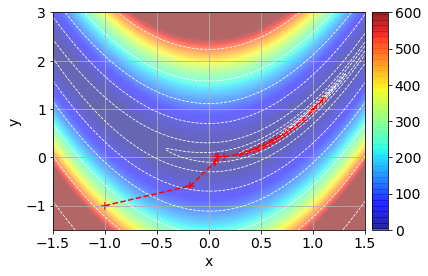

In [6]:
fig, ax = plt.subplots()
plt.scatter(x_smpld, y_smpld, color='red', s=50, marker="+")
plt.plot(x_smpld, y_smpld, "--", color='red')
im = plt.imshow(obj_ros.plot().T, cmap='jet', alpha=0.6,
                vmin=0.0, vmax=600, extent=[1.5,-1.5,-1.5,3.0])
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
cs = plt.contour(obj_ros.plot().T,
                 levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],
                 extent=[-1.5,1.5,3.0,-1.5],
                 colors="white",
                 linewidths=(0.8,),
                 linestyles='--')
plt.gca().invert_xaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax.set_aspect('auto')
plt.show()

For the second test, we will test the steppest-descent approach using the same stepper.

In [7]:
NLSDsolver = occamypy.NLCG(Stop, beta_type="SD")
Ros_prob = Rosenbrock(x_init, y_init) #Resetting the problem
NLSDsolver.setDefaults(save_obj=True, save_model=True)
NLSDsolver.run(Ros_prob, verbose=True)

#Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(NLSDsolver.model)):
    x_smpld.append(NLSDsolver.model[i].getNdArray()[0])
    y_smpld.append(NLSDsolver.model[i].getNdArray()[1])

##########################################################################################
			NON-LINEAR STEEPEST-DESCENT SOLVER 
	Restart folder: /tmp/restart_2021-02-17T11-07-15.296457/
##########################################################################################

iter = 0000, obj = 4.04000e+02, resnorm = 4.04e+02, gradnorm = 8.98e+02, feval = 1, geval = 1
iter = 0001, obj = 4.00632e+01, resnorm = 4.01e+01, gradnorm = 1.33e+02, feval = 4, geval = 2
iter = 0002, obj = 1.38669e+00, resnorm = 1.39e+00, gradnorm = 1.31e+01, feval = 7, geval = 3
iter = 0003, obj = 9.47697e-01, resnorm = 9.48e-01, gradnorm = 1.97e+00, feval = 10, geval = 4
iter = 0004, obj = 9.09671e-01, resnorm = 9.10e-01, gradnorm = 1.93e+00, feval = 13, geval = 5
iter = 0005, obj = 5.52153e-01, resnorm = 5.52e-01, gradnorm = 8.04e+00, feval = 16, geval = 6
iter = 0006, obj = 4.41805e-01, resnorm = 4.42e-01, gradnorm = 1.10e+00, feval = 23, geval = 7
iter = 0007, obj = 4.33636e-01, resnorm = 4.34e-01, gradno

iter = 0206, obj = 7.34136e-02, resnorm = 7.34e-02, gradnorm = 5.75e-01, feval = 623, geval = 207
iter = 0207, obj = 7.30464e-02, resnorm = 7.30e-02, gradnorm = 3.60e-01, feval = 626, geval = 208
iter = 0208, obj = 7.26822e-02, resnorm = 7.27e-02, gradnorm = 5.72e-01, feval = 629, geval = 209
iter = 0209, obj = 7.23204e-02, resnorm = 7.23e-02, gradnorm = 3.58e-01, feval = 632, geval = 210
iter = 0210, obj = 7.19617e-02, resnorm = 7.20e-02, gradnorm = 5.68e-01, feval = 635, geval = 211
iter = 0211, obj = 7.16053e-02, resnorm = 7.16e-02, gradnorm = 3.56e-01, feval = 638, geval = 212
iter = 0212, obj = 7.12518e-02, resnorm = 7.13e-02, gradnorm = 5.64e-01, feval = 641, geval = 213
iter = 0213, obj = 7.09007e-02, resnorm = 7.09e-02, gradnorm = 3.53e-01, feval = 644, geval = 214
iter = 0214, obj = 7.05525e-02, resnorm = 7.06e-02, gradnorm = 5.61e-01, feval = 647, geval = 215
iter = 0215, obj = 7.02065e-02, resnorm = 7.02e-02, gradnorm = 3.51e-01, feval = 650, geval = 216
iter = 0216, obj = 6

iter = 0405, obj = 3.20537e-02, resnorm = 3.21e-02, gradnorm = 2.20e-01, feval = 1220, geval = 406
iter = 0406, obj = 3.19393e-02, resnorm = 3.19e-02, gradnorm = 3.48e-01, feval = 1223, geval = 407
iter = 0407, obj = 3.18253e-02, resnorm = 3.18e-02, gradnorm = 2.19e-01, feval = 1226, geval = 408
iter = 0408, obj = 3.17119e-02, resnorm = 3.17e-02, gradnorm = 3.46e-01, feval = 1229, geval = 409
iter = 0409, obj = 3.15991e-02, resnorm = 3.16e-02, gradnorm = 2.18e-01, feval = 1232, geval = 410
iter = 0410, obj = 3.14867e-02, resnorm = 3.15e-02, gradnorm = 3.45e-01, feval = 1235, geval = 411
iter = 0411, obj = 3.13749e-02, resnorm = 3.14e-02, gradnorm = 2.17e-01, feval = 1238, geval = 412
iter = 0412, obj = 3.12636e-02, resnorm = 3.13e-02, gradnorm = 3.44e-01, feval = 1241, geval = 413
iter = 0413, obj = 3.11529e-02, resnorm = 3.12e-02, gradnorm = 2.16e-01, feval = 1244, geval = 414
iter = 0414, obj = 3.10426e-02, resnorm = 3.10e-02, gradnorm = 3.42e-01, feval = 1247, geval = 415
iter = 041

iter = 0597, obj = 1.71169e-02, resnorm = 1.71e-02, gradnorm = 1.54e-01, feval = 1796, geval = 598
iter = 0598, obj = 1.70653e-02, resnorm = 1.71e-02, gradnorm = 2.43e-01, feval = 1799, geval = 599
iter = 0599, obj = 1.70140e-02, resnorm = 1.70e-02, gradnorm = 1.54e-01, feval = 1802, geval = 600
iter = 0600, obj = 1.69628e-02, resnorm = 1.70e-02, gradnorm = 2.43e-01, feval = 1805, geval = 601
iter = 0601, obj = 1.69118e-02, resnorm = 1.69e-02, gradnorm = 1.53e-01, feval = 1808, geval = 602
iter = 0602, obj = 1.68609e-02, resnorm = 1.69e-02, gradnorm = 2.42e-01, feval = 1811, geval = 603
iter = 0603, obj = 1.68103e-02, resnorm = 1.68e-02, gradnorm = 1.53e-01, feval = 1814, geval = 604
iter = 0604, obj = 1.67599e-02, resnorm = 1.68e-02, gradnorm = 2.41e-01, feval = 1817, geval = 605
iter = 0605, obj = 1.67096e-02, resnorm = 1.67e-02, gradnorm = 1.52e-01, feval = 1820, geval = 606
iter = 0606, obj = 1.66595e-02, resnorm = 1.67e-02, gradnorm = 2.40e-01, feval = 1823, geval = 607
iter = 060

iter = 0778, obj = 1.02021e-02, resnorm = 1.02e-02, gradnorm = 1.83e-01, feval = 2339, geval = 779
iter = 0779, obj = 1.01743e-02, resnorm = 1.02e-02, gradnorm = 1.16e-01, feval = 2342, geval = 780
iter = 0780, obj = 1.01467e-02, resnorm = 1.01e-02, gradnorm = 1.83e-01, feval = 2345, geval = 781
iter = 0781, obj = 1.01191e-02, resnorm = 1.01e-02, gradnorm = 1.16e-01, feval = 2348, geval = 782
iter = 0782, obj = 1.00916e-02, resnorm = 1.01e-02, gradnorm = 1.82e-01, feval = 2351, geval = 783
iter = 0783, obj = 1.00642e-02, resnorm = 1.01e-02, gradnorm = 1.15e-01, feval = 2354, geval = 784
iter = 0784, obj = 1.00370e-02, resnorm = 1.00e-02, gradnorm = 1.82e-01, feval = 2357, geval = 785
iter = 0785, obj = 1.00097e-02, resnorm = 1.00e-02, gradnorm = 1.15e-01, feval = 2360, geval = 786
iter = 0786, obj = 9.98262e-03, resnorm = 9.98e-03, gradnorm = 1.81e-01, feval = 2363, geval = 787
iter = 0787, obj = 9.95558e-03, resnorm = 9.96e-03, gradnorm = 1.15e-01, feval = 2366, geval = 788
iter = 078

iter = 0954, obj = 6.42881e-03, resnorm = 6.43e-03, gradnorm = 1.43e-01, feval = 2867, geval = 955
iter = 0955, obj = 6.41253e-03, resnorm = 6.41e-03, gradnorm = 9.04e-02, feval = 2870, geval = 956
iter = 0956, obj = 6.39629e-03, resnorm = 6.40e-03, gradnorm = 1.43e-01, feval = 2873, geval = 957
iter = 0957, obj = 6.38010e-03, resnorm = 6.38e-03, gradnorm = 9.02e-02, feval = 2876, geval = 958
iter = 0958, obj = 6.36396e-03, resnorm = 6.36e-03, gradnorm = 1.42e-01, feval = 2879, geval = 959
iter = 0959, obj = 6.34786e-03, resnorm = 6.35e-03, gradnorm = 8.99e-02, feval = 2882, geval = 960
iter = 0960, obj = 6.33181e-03, resnorm = 6.33e-03, gradnorm = 1.42e-01, feval = 2885, geval = 961
iter = 0961, obj = 6.31580e-03, resnorm = 6.32e-03, gradnorm = 8.97e-02, feval = 2888, geval = 962
iter = 0962, obj = 6.29984e-03, resnorm = 6.30e-03, gradnorm = 1.41e-01, feval = 2891, geval = 963
iter = 0963, obj = 6.28393e-03, resnorm = 6.28e-03, gradnorm = 8.95e-02, feval = 2894, geval = 964
iter = 096

Let's again plot the optimization path. In this case, the algorithm finds only falls close to the vicinity of the global minimum but does not reach even after 1000 iteration. In the figure below, we can see that the algorithm is sampling most of the objective function within the parabolic valley.

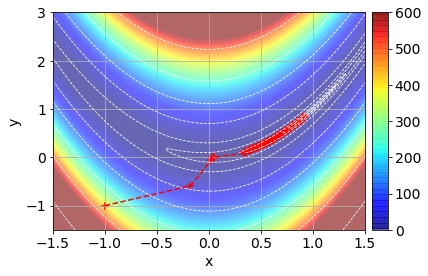

In [8]:
fig, ax = plt.subplots()
# im=plt.imshow(obj_ros_np.T,cmap='jet',vmin=0.0,vmax=600,extent=[-1.5,1.5,-1.0,3.0])
plt.scatter(x_smpld, y_smpld, color='red', s=50, marker="+")
plt.plot(x_smpld, y_smpld,"--", color='red')
im = plt.imshow(obj_ros.plot().T, cmap='jet', alpha=0.6,
                vmin=0.0, vmax=600, extent=[1.5,-1.5,-1.5,3.0])
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
cs = plt.contour(obj_ros.plot().T,
                 levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],
                 extent=[-1.5,1.5,3.0,-1.5],
                 colors="white",
                 linewidths=(0.8,),
                 linestyles='--')
plt.gca().invert_xaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax.set_aspect('auto')
plt.show()

In the third test, let's apply the BFGS algorithm to find the function's global minimum.

In [9]:
ParabStep = occamypy.ParabolicStep() #Again we use the same parabolic stepper as before
BFGSsolver = occamypy.LBFGS(Stop, stepper=ParabStep)
Ros_prob = Rosenbrock(x_init, y_init) #Resetting the problem
BFGSsolver.setDefaults(save_obj=True, save_model=True)
BFGSsolver.run(Ros_prob, verbose=True)

#Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(BFGSsolver.model)):
    x_smpld.append(BFGSsolver.model[i].getNdArray()[0])
    y_smpld.append(BFGSsolver.model[i].getNdArray()[1])

##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm 
Restart folder: /tmp/restart_2021-02-17T11-07-16.874219/
##########################################################################################

iter = 0000, obj = 4.04000e+02, resnorm = 4.04e+02, gradnorm = 8.98e+02, feval = 1, geval = 1
iter = 0001, obj = 4.00632e+01, resnorm = 4.01e+01, gradnorm = 1.33e+02, feval = 4, geval = 2
iter = 0002, obj = 1.47062e+00, resnorm = 1.47e+00, gradnorm = 1.50e+01, feval = 7, geval = 3
iter = 0003, obj = 8.58417e-01, resnorm = 8.58e-01, gradnorm = 2.09e+00, feval = 10, geval = 4
iter = 0004, obj = 8.50009e-01, resnorm = 8.50e-01, gradnorm = 2.01e+00, feval = 13, geval = 5
iter = 0005, obj = 7.40017e-01, resnorm = 7.40e-01, gradnorm = 8.34e+00, feval = 16, geval = 6
iter = 0006, obj = 6.72390e-01, resnorm = 6.72e-01, gradnorm = 2.65e+00, feval = 19, geval = 7
iter = 0007, obj = 5.62078e-01, resnorm = 5.62e

The algorithm has precisely reached the global minimum in 24 iterations. We can clearly see that it is able to find an approximation of the local curvature of the objective function. In fact, it needs to sample very few points within the parabolic-shaped valley. 

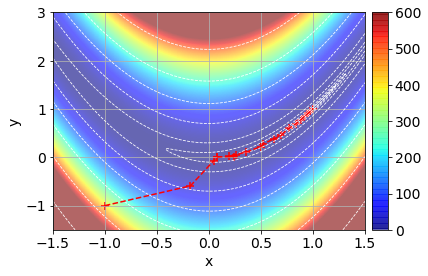

In [10]:
fig, ax = plt.subplots()
plt.scatter(x_smpld, y_smpld, color='red', s=50, marker="+")
plt.plot(x_smpld, y_smpld, "--", color='red')
im = plt.imshow(obj_ros.plot().T, cmap='jet', alpha=.6,
                vmin=0.0, vmax=600, extent=[1.5,-1.5,-1.5,3.0])
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
cs = plt.contour(obj_ros.plot().T,
                 levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],
                 extent=[-1.5,1.5,3.0,-1.5],
                 colors="white",
                 linewidths=(0.8,),
                 linestyles='--')
plt.gca().invert_xaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax.set_aspect('auto')
plt.show()

Let's try to solve the same problem using the steeper described by Nocedal and Wright (1999) in the Algorithm 3.2 on page 59.

In [11]:
WolfeStep = occamypy.StrongWolfe(alpha=0.0) #We now use a stepper that satisfies the strong Wolfe conditions
BFGSsolver = occamypy.LBFGS(Stop, stepper=WolfeStep)
Ros_prob = Rosenbrock(x_init, y_init) #Resetting the problem
BFGSsolver.setDefaults(save_obj=True, save_model=True)
BFGSsolver.run(Ros_prob, verbose=True)

#Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(BFGSsolver.model)):
    x_smpld.append(BFGSsolver.model[i].getNdArray()[0])
    y_smpld.append(BFGSsolver.model[i].getNdArray()[1])

##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm 
Restart folder: /tmp/restart_2021-02-17T11-07-17.339894/
##########################################################################################

iter = 0000, obj = 4.04000e+02, resnorm = 4.04e+02, gradnorm = 8.98e+02, feval = 1, geval = 1
iter = 0001, obj = 1.36247e+02, resnorm = 1.36e+02, gradnorm = 3.63e+02, feval = 2, geval = 2
iter = 0002, obj = 5.53769e+01, resnorm = 5.54e+01, gradnorm = 1.81e+02, feval = 3, geval = 3
iter = 0003, obj = 1.77234e+01, resnorm = 1.77e+01, gradnorm = 8.53e+01, feval = 4, geval = 4
iter = 0004, obj = 4.91376e+00, resnorm = 4.91e+00, gradnorm = 3.96e+01, feval = 5, geval = 5
iter = 0005, obj = 1.35174e+00, resnorm = 1.35e+00, gradnorm = 1.43e+01, feval = 6, geval = 6
iter = 0006, obj = 7.80486e-01, resnorm = 7.80e-01, gradnorm = 2.83e+00, feval = 7, geval = 7
iter = 0007, obj = 7.38601e-01, resnorm = 7.39e-01,

The BFGS algorithm combined with this specific stepper reached the objective function's minimum in 35 iterations with 50 and 45 function and gradient evaluations, respectively.

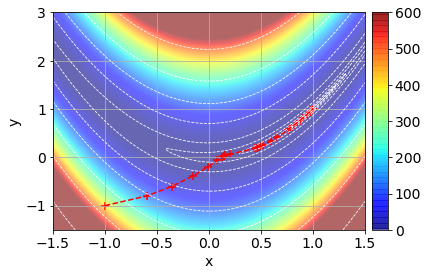

In [12]:
fig, ax = plt.subplots()
plt.scatter(x_smpld, y_smpld, color='red', s=50, marker="+")
plt.plot(x_smpld, y_smpld, "--", color='red')
im = plt.imshow(obj_ros.plot().T, cmap='jet', alpha=.6,
                vmin=0.0, vmax=600, extent=[1.5,-1.5,-1.5,3.0])
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
cs = plt.contour(obj_ros.plot().T,
                 levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],
                 extent=[-1.5,1.5,3.0,-1.5],
                 colors="white",
                 linewidths=(0.8,),
                 linestyles='--')
plt.gca().invert_xaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax.set_aspect('auto')
plt.show()

Finally, let's test again the BFGS method but this time employing the line-search algorithm proposed by More and Thuente (1994). Their line-search method uses a backeting approach in which the strong Wolfe conditions are verified for the tested point. In this case, if these conditons are met, then the method was successful.

In [13]:
BFGSsolver = occamypy.LBFGS(Stop)
Ros_prob = Rosenbrock(x_init, y_init) #Resetting the problem
BFGSsolver.setDefaults(save_obj=True, save_model=True)
BFGSsolver.run(Ros_prob, verbose=True)
#Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(BFGSsolver.model)):
    x_smpld.append(BFGSsolver.model[i].getNdArray()[0])
    y_smpld.append(BFGSsolver.model[i].getNdArray()[1])

##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm 
Restart folder: /tmp/restart_2021-02-17T11-07-17.816587/
##########################################################################################

iter = 0000, obj = 4.04000e+02, resnorm = 4.04e+02, gradnorm = 8.98e+02, feval = 1, geval = 1
iter = 0001, obj = 1.36247e+02, resnorm = 1.36e+02, gradnorm = 3.63e+02, feval = 2, geval = 2
iter = 0002, obj = 5.53769e+01, resnorm = 5.54e+01, gradnorm = 1.81e+02, feval = 3, geval = 3
iter = 0003, obj = 1.77234e+01, resnorm = 1.77e+01, gradnorm = 8.53e+01, feval = 4, geval = 4
iter = 0004, obj = 4.91376e+00, resnorm = 4.91e+00, gradnorm = 3.96e+01, feval = 5, geval = 5
iter = 0005, obj = 1.35174e+00, resnorm = 1.35e+00, gradnorm = 1.43e+01, feval = 6, geval = 6
iter = 0006, obj = 7.80486e-01, resnorm = 7.80e-01, gradnorm = 2.83e+00, feval = 7, geval = 7
iter = 0007, obj = 7.38601e-01, resnorm = 7.39e-01,

We can see that the algorithm has reached the global minimum in 36 iterations.
However, since we employed a different stepping method, in which no parabolic interpolation is used during the optimization, the algorithm had to perfom only 41 objective function evaluations as opposed to 73 necessary by the BFGS method when the parabolic stepper was the line-search algorithm of choice.

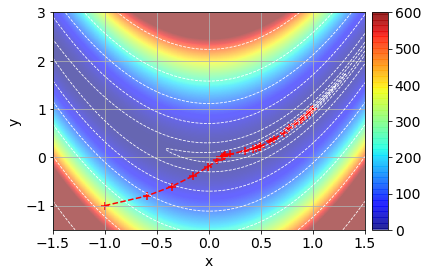

In [14]:
fig, ax = plt.subplots()
plt.scatter(x_smpld, y_smpld, color='red', s=50, marker="+")
plt.plot(x_smpld, y_smpld, "--", color='red')
im = plt.imshow(obj_ros.plot().T, cmap='jet', alpha=.6,
                vmin=0.0, vmax=600, extent=[1.5,-1.5,-1.5,3.0])
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
cs = plt.contour(obj_ros.plot().T,
                 levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],
                 extent=[-1.5,1.5,3.0,-1.5],
                 colors="white",
                 linewidths=(0.8,),
                 linestyles='--')
plt.gca().invert_xaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax.set_aspect('auto')
plt.show()

### Constrained non-linear optimization 

We now try to solve the save non-linear problem but we impose maximum and minimum boundary conditions as follows:
\begin{equation}
\phi(x,y) = (1-x)^2 + 100 (y-x^2)^2,\\
\text{s.t.} \; x_l \leq x \leq x_m \; \text{and} \; y_l \leq y \leq y_m 
\end{equation}
where $x_l$, $y_l$, $x_m$, and $y_m$ represent the minimum and maximum allowed values for each optimization variable, respectively. Let's first define a problem object with two bound vectors having the inequality conditions shown in the previous equations. To solve such problem, we employ the L-BFGS-B algorithm proposed by Byrd et al. (1995). Let's try with some bounds that contains the global minimum of the objective function.

In [15]:
# Lower and upper bounds and associtated vectors
xl = -1.2
yl = -1.2
xu = 1.2
yu = 2.0
minBound = occamypy.VectorNumpy(np.array((xl, yl)))
maxBound = occamypy.VectorNumpy(np.array((xu, yu)))
niter = 1000
Stop  = occamypy.BasicStopper(niter=niter, tolg_proj=1e-32)
BFGSBsolver = occamypy.LBFGSB(Stop, m_steps=10)
Ros_prob = Rosenbrock(x_init, y_init, minBound, maxBound) #Resetting the problem
BFGSBsolver.setDefaults(save_obj=True, save_model=True)
BFGSBsolver.run(Ros_prob,verbose=True)
#Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(BFGSBsolver.model)):
    x_smpld.append(BFGSBsolver.model[i].getNdArray()[0])
    y_smpld.append(BFGSBsolver.model[i].getNdArray()[1])
# Setting bounds for plotting
minBoundNd = minBound.getNdArray()
maxBoundNd = maxBound.getNdArray()
bounds_points_x = np.array([minBoundNd[0],minBoundNd[0],maxBoundNd[0],maxBoundNd[0],minBoundNd[0]])
bounds_points_y = np.array([minBoundNd[1],maxBoundNd[1],maxBoundNd[1],minBoundNd[1],minBoundNd[1]])

##########################################################################################
Limited-memory Broyden-Fletcher-Goldfarb-Shanno with Bounds (L-BFGS-B) algorithm 
Maximum number of steps to be used for Hessian inverse estimation: 10 
Restart folder: /tmp/restart_2021-02-17T11-07-18.294138/
##########################################################################################

iter = 0000, obj = 4.04000e+02, resnorm = 4.04e+02, gradnorm = 8.98e+02, feval = 1, geval = 1
iter = 0001, obj = 1.49860e+01, resnorm = 1.50e+01, gradnorm = 9.49e+01, feval = 2, geval = 2
iter = 0002, obj = 4.26420e+00, resnorm = 4.26e+00, gradnorm = 3.98e+01, feval = 3, geval = 3
iter = 0003, obj = 1.74110e+00, resnorm = 1.74e+00, gradnorm = 3.77e+00, feval = 4, geval = 4
iter = 0004, obj = 1.71506e+00, resnorm = 1.72e+00, gradnorm = 2.38e+00, feval = 5, geval = 5
iter = 0005, obj = 1.66664e+00, resnorm = 1.67e+00, gradnorm = 2.60e+00, feval = 6, geval = 6
iter = 0006, obj = 1.07118e+00, resnorm = 1

The method is able to reach the global minimum since it is contianed within the provided bounds (plotted with white dashed segments). 

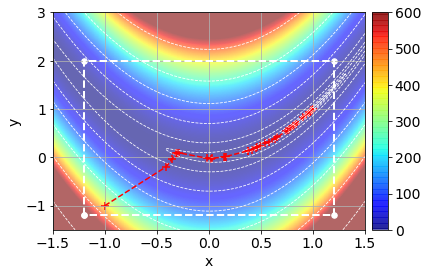

In [16]:
fig, ax = plt.subplots()
plt.scatter(x_smpld, y_smpld, color='red', s=50, marker="+")
plt.plot(x_smpld, y_smpld, "--", color='red')
plt.scatter(bounds_points_x, bounds_points_y, marker="o", color='w', s=30)
plt.plot(bounds_points_x, bounds_points_y, "--", color='w', linewidth=2)
im = plt.imshow(obj_ros.plot().T, cmap='jet', alpha=.6,
                vmin=0.0, vmax=600, extent=[1.5,-1.5,-1.5,3.0])
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
cs = plt.contour(obj_ros.plot().T,
                 levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],
                 extent=[-1.5,1.5,3.0,-1.5],
                 colors="white",
                 linewidths=(0.8,),
                 linestyles='--')
plt.gca().invert_xaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax.set_aspect('auto')
plt.show()

Let's now try to reduce the upper bounds and see where the method stops.

In [17]:
# Lower and upper bounds and associtated vectors
xl = -1.2
yl = -1.2
xu = 0.5
yu = 1.0
minBound = occamypy.VectorNumpy(np.array((xl, yl)))
maxBound = occamypy.VectorNumpy(np.array((xu, yu)))
niter = 1000
Stop  = occamypy.BasicStopper(niter=niter, tolg_proj=1e-32)
BFGSBsolver = occamypy.LBFGSB(Stop, m_steps=10)
Ros_prob = Rosenbrock(x_init, y_init, minBound, maxBound) #Resetting the problem
BFGSBsolver.setDefaults(save_obj=True, save_model=True)
BFGSBsolver.run(Ros_prob,verbose=True)
#Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(BFGSBsolver.model)):
    x_smpld.append(BFGSBsolver.model[i].getNdArray()[0])
    y_smpld.append(BFGSBsolver.model[i].getNdArray()[1])
# Setting bounds for plotting
minBoundNd = minBound.getNdArray()
maxBoundNd = maxBound.getNdArray()
bounds_points_x = np.array([minBoundNd[0],minBoundNd[0],maxBoundNd[0],maxBoundNd[0],minBoundNd[0]])
bounds_points_y = np.array([minBoundNd[1],maxBoundNd[1],maxBoundNd[1],minBoundNd[1],minBoundNd[1]])

##########################################################################################
Limited-memory Broyden-Fletcher-Goldfarb-Shanno with Bounds (L-BFGS-B) algorithm 
Maximum number of steps to be used for Hessian inverse estimation: 10 
Restart folder: /tmp/restart_2021-02-17T11-07-18.850013/
##########################################################################################

iter = 0000, obj = 4.04000e+02, resnorm = 4.04e+02, gradnorm = 8.98e+02, feval = 1, geval = 1
iter = 0001, obj = 1.49200e+01, resnorm = 1.49e+01, gradnorm = 9.40e+01, feval = 2, geval = 2
iter = 0002, obj = 4.33232e+00, resnorm = 4.33e+00, gradnorm = 4.02e+01, feval = 3, geval = 3
iter = 0003, obj = 1.71751e+00, resnorm = 1.72e+00, gradnorm = 3.79e+00, feval = 4, geval = 4
iter = 0004, obj = 1.69075e+00, resnorm = 1.69e+00, gradnorm = 2.37e+00, feval = 5, geval = 5
iter = 0005, obj = 1.64343e+00, resnorm = 1.64e+00, gradnorm = 2.59e+00, feval = 6, geval = 6
iter = 0006, obj = 1.04766e+00, resnorm = 1

The algorithm reaches the closest feasible minimum point as we can see from the plot below. This point is indeed positioned at on of the boundary.

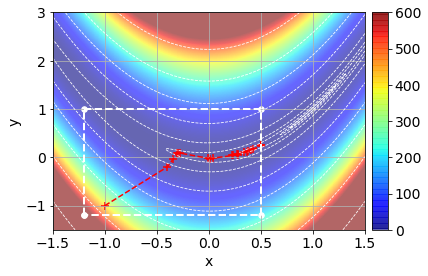

In [18]:
fig, ax = plt.subplots()
plt.scatter(x_smpld, y_smpld, color='red', s=50, marker="+")
plt.plot(x_smpld, y_smpld, "--", color='red')
plt.scatter(bounds_points_x, bounds_points_y, marker="o", color='w', s=30)
plt.plot(bounds_points_x, bounds_points_y, "--", color='w', linewidth=2)
im = plt.imshow(obj_ros.plot().T, cmap='jet', alpha=.6,
                vmin=0.0, vmax=600, extent=[1.5,-1.5,-1.5,3.0])
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
cs = plt.contour(obj_ros.plot().T,
                 levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],
                 extent=[-1.5,1.5,3.0,-1.5],
                 colors="white",
                 linewidths=(0.8,),
                 linestyles='--')
plt.gca().invert_xaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax.set_aspect('auto')
plt.show()

In [19]:
# Lower and upper bounds and associtated vectors
xl = -1.2
yl = -1.2
xu = 0.0
yu = 0.0
minBound = occamypy.VectorNumpy(np.array((xl, yl)))
maxBound = occamypy.VectorNumpy(np.array((xu, yu)))
niter = 1000
Stop  = occamypy.BasicStopper(niter=niter, tolg_proj=1e-32)
BFGSBsolver = occamypy.LBFGSB(Stop, m_steps=10)
Ros_prob = Rosenbrock(x_init, y_init, minBound, maxBound) #Resetting the problem
BFGSBsolver.setDefaults(save_obj=True, save_model=True)
BFGSBsolver.run(Ros_prob,verbose=True)
#Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(BFGSBsolver.model)):
    x_smpld.append(BFGSBsolver.model[i].getNdArray()[0])
    y_smpld.append(BFGSBsolver.model[i].getNdArray()[1])
# Setting bounds for plotting
minBoundNd = minBound.getNdArray()
maxBoundNd = maxBound.getNdArray()
bounds_points_x = np.array([minBoundNd[0],minBoundNd[0],maxBoundNd[0],maxBoundNd[0],minBoundNd[0]])
bounds_points_y = np.array([minBoundNd[1],maxBoundNd[1],maxBoundNd[1],minBoundNd[1],minBoundNd[1]])

##########################################################################################
Limited-memory Broyden-Fletcher-Goldfarb-Shanno with Bounds (L-BFGS-B) algorithm 
Maximum number of steps to be used for Hessian inverse estimation: 10 
Restart folder: /tmp/restart_2021-02-17T11-07-19.366126/
##########################################################################################

iter = 0000, obj = 4.04000e+02, resnorm = 4.04e+02, gradnorm = 8.98e+02, feval = 1, geval = 1
iter = 0001, obj = 1.60114e+01, resnorm = 1.60e+01, gradnorm = 8.91e+01, feval = 2, geval = 2
iter = 0002, obj = 5.87440e+00, resnorm = 5.87e+00, gradnorm = 4.73e+01, feval = 3, geval = 3
iter = 0003, obj = 1.44053e+00, resnorm = 1.44e+00, gradnorm = 7.00e+00, feval = 4, geval = 4
iter = 0004, obj = 1.44053e+00, resnorm = 1.44e+00, gradnorm = 7.00e+00, feval = 5, geval = 5
iter = 0005, obj = 1.44053e+00, resnorm = 1.44e+00, gradnorm = 7.00e+00, feval = 6, geval = 6
iter = 0006, obj = 1.44053e+00, resnorm = 1

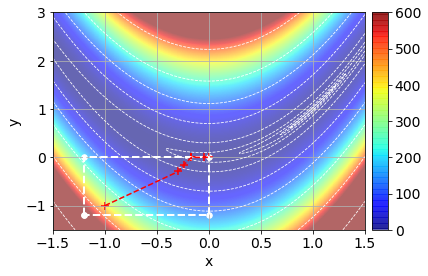

In [20]:
fig, ax = plt.subplots()
plt.scatter(bounds_points_x, bounds_points_y, marker="o", color='w', s=30)
plt.plot(bounds_points_x, bounds_points_y, "--", color='w', linewidth=2)
plt.scatter(x_smpld, y_smpld, color='red', s=50, marker="+")
plt.plot(x_smpld, y_smpld, "--", color='red')
im = plt.imshow(obj_ros.plot().T, cmap='jet', alpha=.6,
                vmin=0.0, vmax=600, extent=[1.5,-1.5,-1.5,3.0])
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
cs = plt.contour(obj_ros.plot().T,
                 levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],
                 extent=[-1.5,1.5,3.0,-1.5],
                 colors="white",
                 linewidths=(0.8,),
                 linestyles='--')
plt.gca().invert_xaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax.set_aspect('auto')
plt.show()

Again, the method is able to reach the closest feasible minimum of the objective function.